In [1]:
import pandas as pd
from reddit_dataclass import RedditData as reddit
import pickle
import matplotlib.pyplot as plt
import scipy.stats as scpstat
import matplotlib.dates as dates
import datetime
from sklearn import metrics
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices

In [2]:
regression_thread_data = pickle.load(open("regression_thread_data.p", 'rb'))

In [3]:
clean_thread_data = pickle.load(open('clean_5_thread_data.p', 'rb'))

In [4]:
calibration = 0.7
calval_regression_thread_data = {}
calval_clean_thread_data = {}
for key in regression_thread_data:
    cutoff = int(len(regression_thread_data[key])*calibration)
    regression_calval = {}
    regression_calval['calibration'] = regression_thread_data[key][:cutoff]
    regression_calval['validation'] = regression_thread_data[key][cutoff:]
    
    thread_calval = {}
    for type in regression_calval:
        thread_calval[type] = (
            clean_thread_data[key][
                clean_thread_data[key].thread_id.isin(
                    regression_calval[type].thread_id
                )
            ]
        )
    calval_regression_thread_data[key] = regression_calval
    calval_clean_thread_data[key] = thread_calval
    
    
    


In [6]:
calval_author_activity = {}

for key in calval_clean_thread_data:
    calval_author_activity[key] = {}
    for type in calval_clean_thread_data[key]:
        author_activity_df = (
            calval_clean_thread_data[key][type][['id', 'author']]
            .groupby('author').count()
            .rename(columns={'id': 'all_activity_count'})
        )
        posts = (
            calval_clean_thread_data[key][type][
            calval_clean_thread_data[key][type].thread_id==calval_clean_thread_data[key][type].id
            ]
        )
        comments = (
            calval_clean_thread_data[key][type][
            calval_clean_thread_data[key][type].thread_id!=calval_clean_thread_data[key][type].id
            ]
        )

        post_activity = (
            posts[['id', 'author']]
            .groupby('author').count()
            .rename(columns={'id': 'post_activity_count'})
        )

        comment_activity = (
            comments[['id', 'author']]
            .groupby('author').count()
            .rename(columns={'id': 'comment_activity_count'})
        )

        for activity_df in [post_activity, comment_activity]:
            author_activity_df = pd.concat(
                (author_activity_df, activity_df), axis=1
            ).fillna(value=0)
        
        calval_author_activity[key][type] = author_activity_df.astype(int)

        calval_regression_thread_data[key][type] = (
            calval_regression_thread_data[key][type].merge(
            calval_author_activity[key][type].reset_index(), on='author'
            )
        )

In [7]:
pickle.dump(calval_regression_thread_data, open('calval_regression_data.p', 'wb'))

In [4]:
author_activity = {}
posts = {}
comments = {}

for key in clean_thread_data:
    author_activity_df = (
        clean_thread_data[key][['id', 'author']]
        .groupby('author').count()
        .rename(columns={'id': 'all_activity_count'})
    )
    posts[key] = (
        clean_thread_data[key][
        clean_thread_data[key].thread_id==clean_thread_data[key].id
        ]
    )
    comments[key] = (
        clean_thread_data[key][
        clean_thread_data[key].thread_id!=clean_thread_data[key].id
        ]
    )

    post_activity = (
        posts[key][['id', 'author']]
        .groupby('author').count()
        .rename(columns={'id': 'post_activity_count'})
    )

    comment_activity = (
        comments[key][['id', 'author']]
        .groupby('author').count()
        .rename(columns={'id': 'comment_activity_count'})
    )

    for activity_df in [post_activity, comment_activity]:
        author_activity_df = pd.concat(
            (author_activity_df, activity_df), axis=1
        ).fillna(value=0)
    
    author_activity[key] = author_activity_df.astype(int)

    regression_thread_data[key] = (
        regression_thread_data[key].merge(
        author_activity[key].reset_index(), on='author'
        )
    )


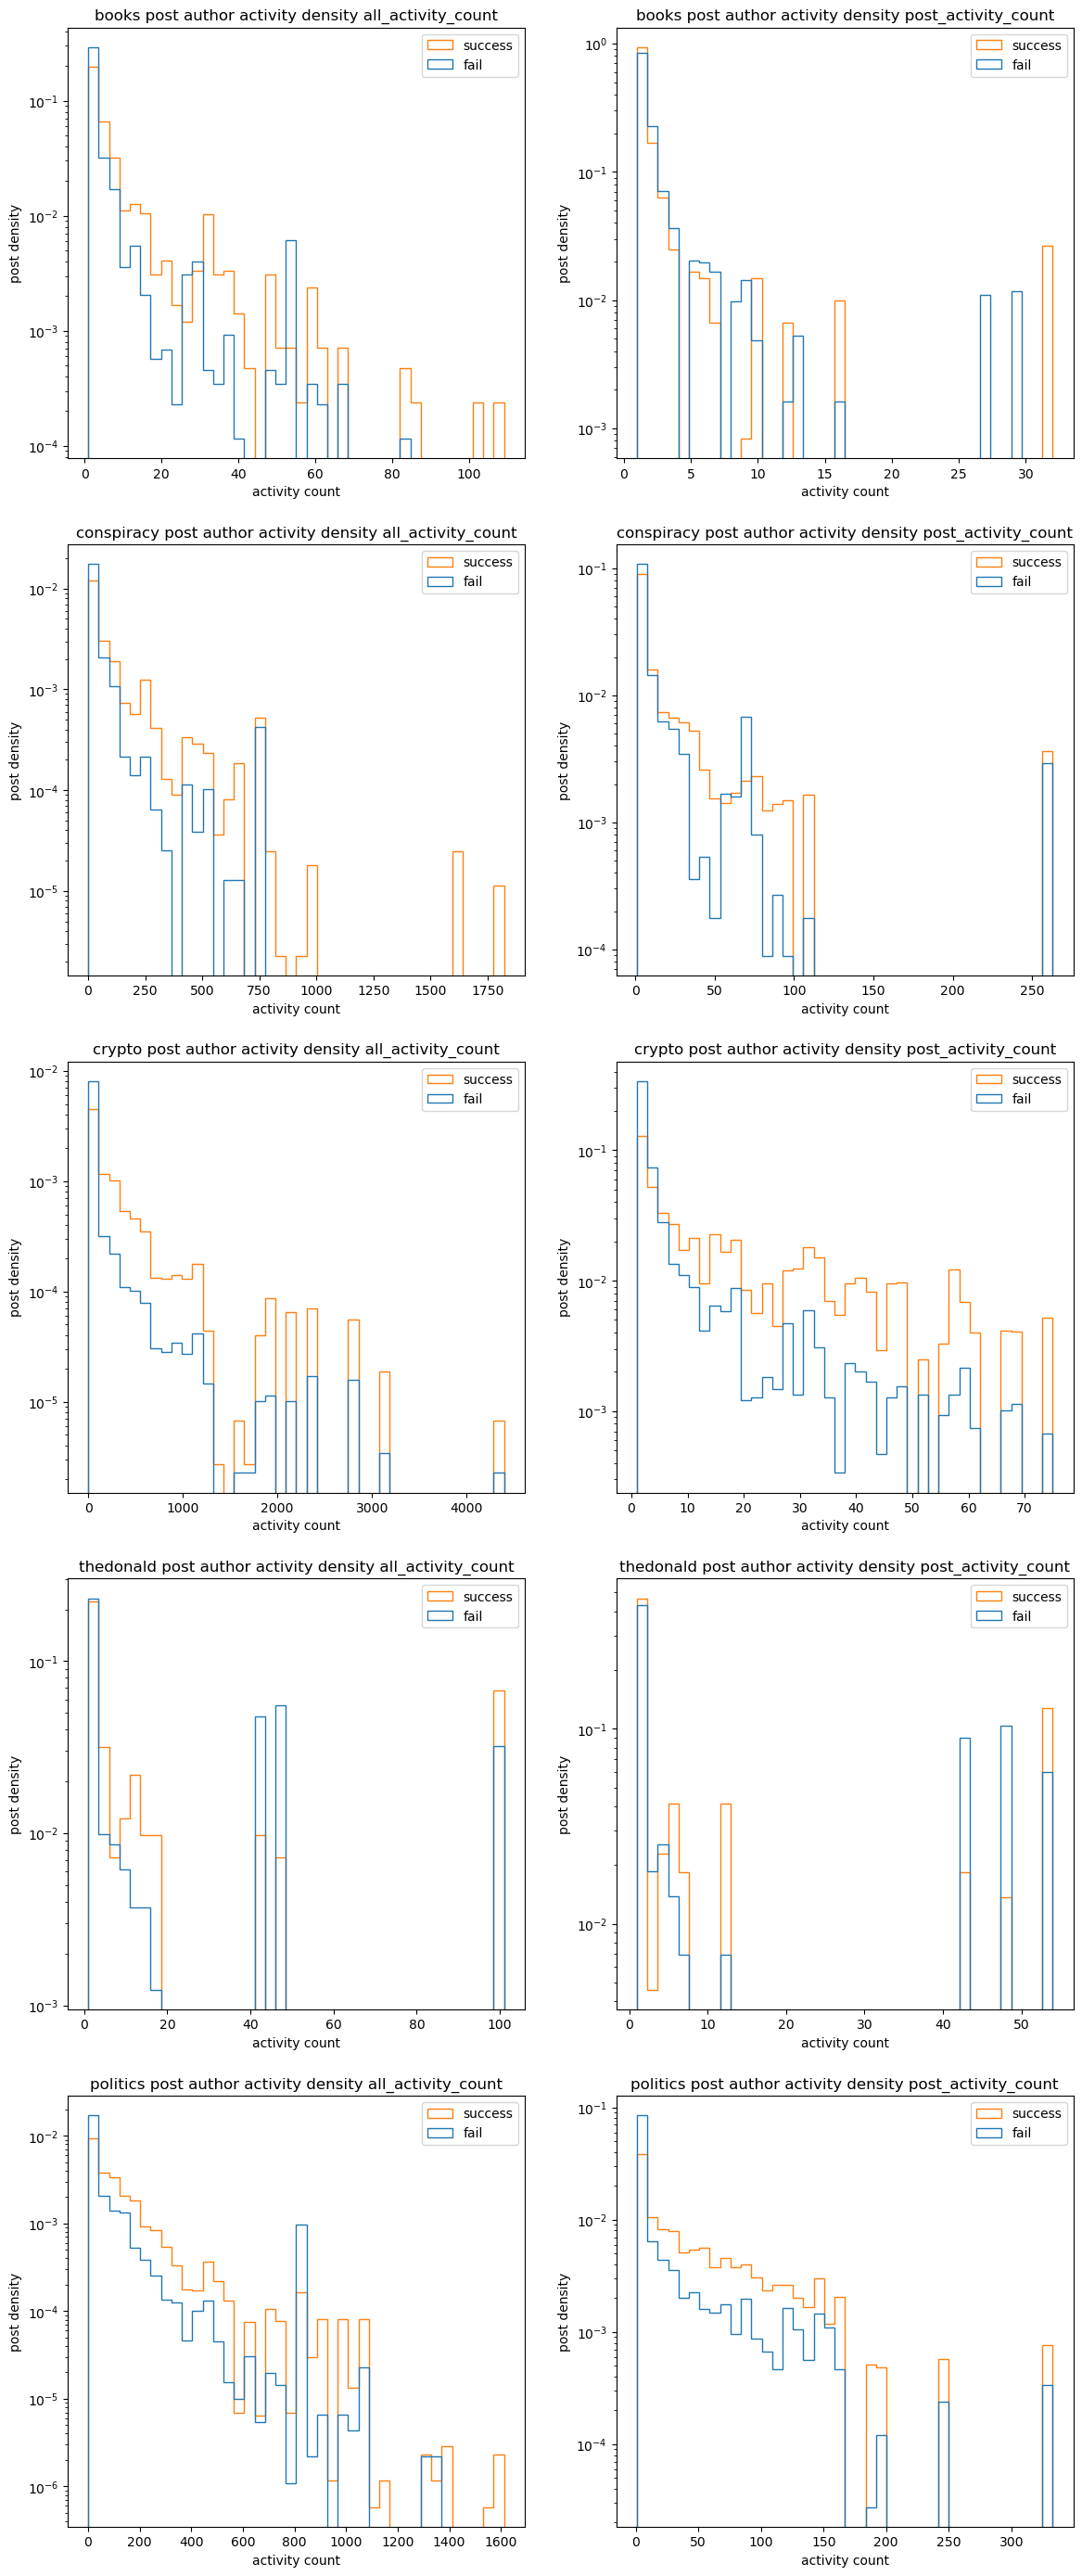

In [11]:
fig, axes = plt.subplots(5,2, figsize=(14, 35))

xlabel = 'activity count'
ylabel = 'post density'
title = 'post author activity density'

activity_cols = ['all_activity_count', 'post_activity_count']

colours = {
    'fail': 'tab:blue',
    'success': 'tab:orange'
}

i=0

for key in regression_thread_data:
    
    success_dict = {
        'success': regression_thread_data[key][
        regression_thread_data[key].success == 1
        ],
        'fail': regression_thread_data[key][
        regression_thread_data[key].success == 0
        ]
    }
    
    for j, col in enumerate(activity_cols):
        plot_bins = {}
        bin_val = 40
        for type in success_dict:
            plot_bins[type] = axes[i,j].hist(success_dict[type][col],
                bins=bin_val, log=True, density=True, stacked=True,
                histtype='step', label=type, color=colours[type])
            bin_val = plot_bins[type][1]

        axes[i,j].set_title(f'{key} {title} {col}')
        axes[i,j].set_xlabel(xlabel)
        axes[i,j].set_ylabel(ylabel)
        axes[i,j].legend()
        
    i += 1

In [14]:
pickle.dump(regression_thread_data, open('regression_thread_data_v2.p', 'wb'))

In [13]:
clean_thread_data['books']

,thread_id,id,timestamp,author,domain,parent,score,subject_sentiment_score,body_sentiment_score,date,level,parent_comment
0,xsgu8l,xsgu8l,2022-10-01 00:11:11,f44d5bd8146ae4baecd32037a8285c4f99690e85fa022ec5,deadline.com,NaN,1,-0.5719,NaN,2022-10-01,0,NaN
1,xsh6qv,xsh6qv,2022-10-01 00:27:38,703bd9ed6d2b178437b437b99074449db8137f1d00e6f7be,thebookreviewcrew.com,NaN,1,0.0000,NaN,2022-10-01,0,NaN
2,xshdvl,xshdvl,2022-10-01 00:36:53,d9cacaec67989837c343381be2e4d5016c7743d419a34e84,story-arc-blog.com,NaN,1,0.0000,NaN,2022-10-01,0,NaN
3,xsi14p,xsi14p,2022-10-01 01:07:47,c466b9998753e56da1c6050ead680f8d2120eb91e2ef0fb9,self.books,NaN,1,0.0000,0.000000,2022-10-01,0,NaN
4,xsis1h,xsis1h,2022-10-01 01:44:22,920f0705acd330eaf28719163e0801e1155d19b4a213351a,self.books,NaN,1,0.6369,0.127068,2022-10-01,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
111046,yhks0d,iufrknp,2022-10-30 23:58:32,c1487bafa8953938eee4672e4d97aed3997d2905ed77e871,NaN,iuede6w,1,NaN,0.016200,2022-10-30,2,iuede6w
111047,yhf64b,iufrm4t,2022-10-30 23:58:52,4a2ae05277cb0aa85a64fdec8358f8f628b8f48d137d1944,NaN,iue83in,1,NaN,-0.802100,2022-10-30,2,iue83in
111049,yeibp7,iufroik,2022-10-30 23:59:23,00b26decc84c6c93f88dc30f80178822d4c1bbd4022d4e5e,NaN,ityf6e7,1,NaN,0.615850,2022-10-30,2,ityf6e7
111050,yhks0d,iufrp7w,2022-10-30 23:59:33,95437de983251f9f21c0dc6da4c8298daffb9677ecd86566,NaN,iuede6w,1,NaN,0.296000,2022-10-30,2,iuede6w


In [15]:
def get_timediffs(df, func='mean'):
    if len(df) < 2:
        return pd.NaT
    else:
        df = df.sort_values(by='timestamp')
        time_deltas = df['timestamp'].diff()
        if func == 'mean':
            return time_deltas.mean()
        elif func == 'median':
            return time_deltas.median()
        elif func == 'std':
            return time_deltas.std()
        elif func == 'sem':
            return time_deltas.sem()
        else:
            raise KeyError(func)

In [22]:
clean_thread_data['books'][clean_thread_data['books'].thread_id == clean_thread_data['books'].id]

,thread_id,id,timestamp,author,domain,parent,score,subject_sentiment_score,body_sentiment_score,date,level,parent_comment
0,xsgu8l,xsgu8l,2022-10-01 00:11:11,f44d5bd8146ae4baecd32037a8285c4f99690e85fa022ec5,deadline.com,NaN,1,-0.5719,NaN,2022-10-01,0,NaN
1,xsh6qv,xsh6qv,2022-10-01 00:27:38,703bd9ed6d2b178437b437b99074449db8137f1d00e6f7be,thebookreviewcrew.com,NaN,1,0.0000,NaN,2022-10-01,0,NaN
2,xshdvl,xshdvl,2022-10-01 00:36:53,d9cacaec67989837c343381be2e4d5016c7743d419a34e84,story-arc-blog.com,NaN,1,0.0000,NaN,2022-10-01,0,NaN
3,xsi14p,xsi14p,2022-10-01 01:07:47,c466b9998753e56da1c6050ead680f8d2120eb91e2ef0fb9,self.books,NaN,1,0.0000,0.000000,2022-10-01,0,NaN
4,xsis1h,xsis1h,2022-10-01 01:44:22,920f0705acd330eaf28719163e0801e1155d19b4a213351a,self.books,NaN,1,0.6369,0.127068,2022-10-01,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5155,yhubu4,yhubu4,2022-10-30 23:47:20,452ee4f79a00b3bb4551bd3004e2eac706a6ccbf02571b30,self.books,NaN,1,0.3612,0.000000,2022-10-30,0,NaN
5156,yhufba,yhufba,2022-10-30 23:50:57,c87b1b35b64a2745a582aa1561ba7a2109d7bb62058269b3,saturdayeveningpost.com,NaN,1,0.0000,NaN,2022-10-30,0,NaN
5157,yhukih,yhukih,2022-10-30 23:56:14,452ee4f79a00b3bb4551bd3004e2eac706a6ccbf02571b30,self.books,NaN,1,0.0000,0.571400,2022-10-30,0,NaN
5158,yhumfc,yhumfc,2022-10-30 23:58:16,85d36ff7b20bc9bbd48ca8c94645d5d491d234585f8f2646,self.books,NaN,1,0.0000,0.000000,2022-10-30,0,NaN
